C:\Users\hp\AppData\Local\Temp\ipykernel_29140\244985008.py:33: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

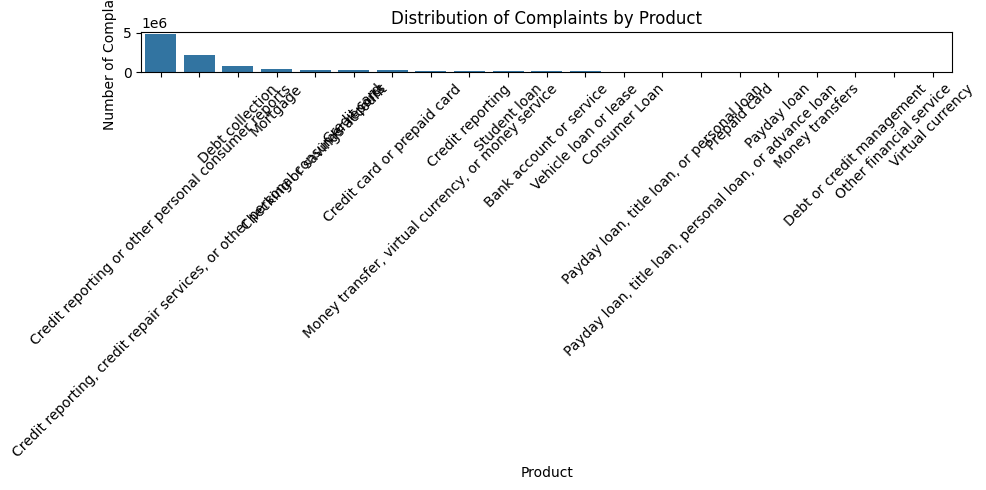

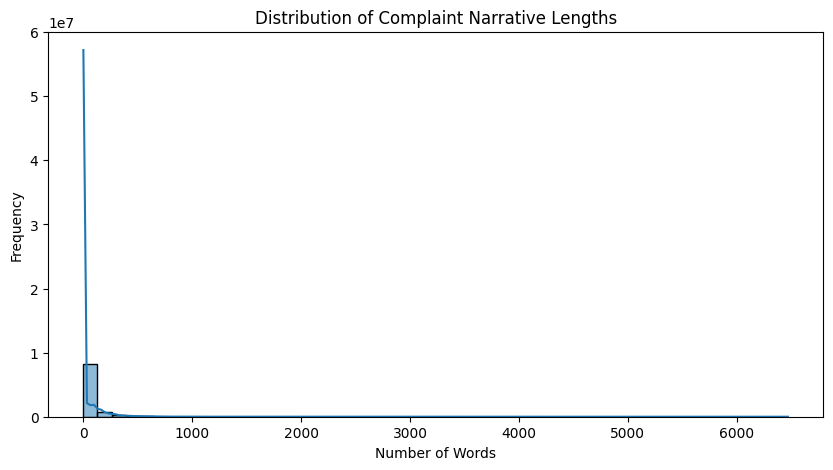

Total complaints: 9609797
With narratives: 2980756
Without narratives: 6629041

🔍 KEY INSIGHTS:

1. The original dataset had 9609797 complaints.
2. Only 2980756 complaints had a narrative; 6629041 did not.
3. After filtering, we have 82164 complaints in the 5 target categories.
4. Most common product with complaints: Credit card
5. Average narrative length: 200.05 words.


In [ ]:
# notebooks/Task1_EDA.ipynb

# -------------------------------------------------------------------
# 📌 Task 1: Exploratory Data Analysis and Data Preprocessing
# -------------------------------------------------------------------

# ✅ Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Ensure plots render in the notebook
%matplotlib inline

# ✅ Constants
RAW_DATA_PATH = "../data/raw/complaints.csv"
CLEANED_DATA_PATH = "../data/processed/filtered_complaints.csv"
TARGET_PRODUCTS = [
    "Credit card", 
    "Personal loan", 
    "Buy Now, Pay Later (BNPL)", 
    "Savings account", 
    "Money transfers"
]

# ✅ Step 1: Load the dataset
# Load the full CFPB complaint dataset into a DataFrame
df = pd.read_csv(RAW_DATA_PATH)

# Preview the first few rows to understand the data structure
df.head()

# ✅ Step 2: Initial EDA to Understand the Data
# Let's check column names, data types, and null values
df.info()
df.describe(include='all')

# ✅ Step 3: Analyze Distribution of Complaints by Product
# This tells us which product categories are most frequently complained about
product_counts = df['Product'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

# ✅ Step 4: Analyze the Length of Complaint Narratives
# First, create a new column with word count of each narrative
# This helps us understand the distribution and identify very short/long complaints
df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))

# Visualize the narrative lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title("Distribution of Complaint Narrative Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# ✅ Step 5: Check How Many Complaints Have Narratives
# We need to remove entries with empty narratives
total_complaints = len(df)
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = total_complaints - with_narrative
print(f"Total complaints: {total_complaints}")
print(f"With narratives: {with_narrative}")
print(f"Without narratives: {without_narrative}")

# ✅ Step 6: Filter Dataset for Project Requirements
# 1. Only include the 5 specified financial products
# 2. Drop entries with empty narratives
df_filtered = df[
    (df['Product'].isin(TARGET_PRODUCTS)) &
    (df['Consumer complaint narrative'].notna())
].copy()

# ✅ Step 7: Clean the Complaint Narratives
# Improve embedding quality by removing unwanted text patterns and lowering case
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove common boilerplate phrases
    text = re.sub(r"i am writing to file a complaint.*?\.", "", text)
    # Remove non-alphabetic characters (optional)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# ✅ Step 8: Save the Cleaned Dataset
# Save as CSV for use in downstream RAG pipeline
os.makedirs("data", exist_ok=True)
df_filtered.to_csv(CLEANED_DATA_PATH, index=False)

# ✅ Step 9: Key Insights Summary
print("\n🔍 KEY INSIGHTS:")
print(f"\n1. The original dataset had {total_complaints} complaints.")
print(f"2. Only {with_narrative} complaints had a narrative; {without_narrative} did not.")
print(f"3. After filtering, we have {len(df_filtered)} complaints in the 5 target categories.")
print("4. Most common product with complaints:", df_filtered['Product'].value_counts().idxmax())
print(f"5. Average narrative length: {df_filtered['narrative_length'].mean():.2f} words.")

# ✅ Final Note:
# The cleaned file saved above will be used for text chunking and vector indexing in the next task.
